In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, f1_score

In [2]:
ANOMALY_LABELS = ['Deviation / Discrepancy - Procedural',
                    'Aircraft Equipment',
                    'Conflict',
                    'Inflight Event / Encounter',
                    'ATC Issue',
                    'Deviation - Altitude',
                    'Deviation - Track / Heading',
                    'Ground Event / Encounter',
                    'Flight Deck / Cabin / Aircraft Event',
                    'Ground Incursion',
                    'Airspace Violation',
                    'Deviation - Speed',
                    'Ground Excursion',
                    'No Specific Anomaly Occurred']

In [3]:
results = pd.read_csv('results-sub.csv')
subset = pd.read_parquet('subset_test_data.parquet')
fs_pred = joblib.load('ypred_fs0.joblib')
zs_pred = joblib.load('ypred_p5_zs.joblib')

In [4]:
ytrue = np.array(subset.Anomaly.values.tolist())
l_values = list(classification_report(ytrue, zs_pred, target_names=ANOMALY_LABELS, output_dict=True).values())
l_keys = list(classification_report(ytrue, zs_pred, target_names=ANOMALY_LABELS, output_dict=True).keys())

/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
f1score = [item['f1-score'] for item in l_values]
llama_results = pd.DataFrame({'Model Name' : ['LLAMA-2-7B']*len(l_values), 'Category' : l_keys, 'f1-score': f1score})

In [6]:
results_full = results[llama_results.columns]
results_full = pd.concat([results_full, llama_results])

In [7]:
models = {'bert':'BERT',
          'nasa':'SafeAeroBERT',
          'alle': 'Longformer',
          'aero': 'AeroBOT',
          'llam':'LLAMA-2-7B'}
short_name = ['BertBase_Unfrz_BCE',
              'SafeAeroBERT_Unfrz_BCE',
              'Longformer_Unfrz_BCE',
              'AeroBOT_BertBase_Unfrz_BCE',
              'LLAMA-2-7B']
cat_exclude = ['No Specific Anomaly Occurred', 'micro avg', 'macro avg', 'weighted avg', 'samples avg']

In [8]:
color_palette = sns.color_palette()
color_palette = sns.color_palette()
model_order = ['SafeAeroBERT_Unfrz_BCE', 'Longformer_Unfrz_BCE', 'AeroBOT_BertBase_Unfrz_BCE', 'BertBase_Unfrz_BCE', 'LLAMA-2-7B']
model_order_bis = ['SafeAeroBERT', 'Longformer', 'AeroBOT', 'BERT', 'LLAMA-2-7B']
model_palette = {model: color_palette[index % len(color_palette)] for index, model in enumerate(model_order)}
model_palette_bis = {model: color_palette[index % len(color_palette)] for index, model in enumerate(model_order_bis)}

In [9]:
results_full['Model'] = results_full['Model Name'].apply(lambda cell: models[cell[:4].lower()])
map = dict(zip(results_full['Model Name'].unique().tolist(), short_name))

In [10]:
results_full['Model Name'] = results_full['Model Name'].apply(lambda cell: map[cell])
results_full = results_full.sort_values(by='f1-score', ascending=True)

/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

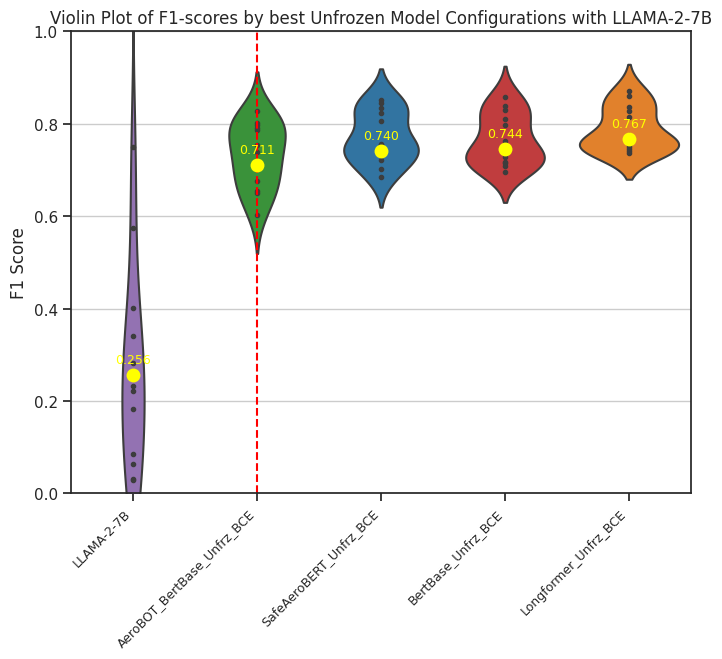

In [11]:
plt.figure(figsize=(8, 6))
sns.set_theme(style="ticks")
plt.grid()
sns.stripplot(data=results_full[results_full['Category'].isin(['macro avg'])], x="Model Name", y="f1-score", color='yellow', size=10, jitter=True)
sns.violinplot(data=results_full[~results_full['Category'].isin(cat_exclude)], x="Model Name", y="f1-score", inner="points", saturation=0.75, palette=model_palette)
plt.title('Violin Plot of F1-scores by best Unfrozen Model Configurations with LLAMA-2-7B')
for i in range(len(results_full[results_full['Category'].isin(['macro avg'])])):
    plt.text(results_full[results_full['Category'].isin(['macro avg'])].iloc[i]['Model Name'], results_full[results_full['Category'].isin(['macro avg'])].iloc[i]['f1-score'] + 0.02, 
             f"{results_full[results_full['Category'].isin(['macro avg'])].iloc[i]['f1-score']:.3f}", ha='center', va='bottom', fontsize=9, color='yellow')

plt.axvline(x=1, color='red', linestyle='--')
plt.ylabel('F1 Score')
plt.xlabel('')
plt.xticks(rotation = 45, ha='right', fontsize=9)
plt.gca().set_ylim(0, 1)
plt.show()

In [62]:
errors_idx = np.where(np.sum(zs_pred, axis=1)==0)[0]
ytrue_gf = ytrue[~errors_idx]
zs_pred_gf = np.array(zs_pred)[~errors_idx]
l_gf_values = list(classification_report(ytrue_gf, zs_pred_gf, target_names=ANOMALY_LABELS, output_dict=True).values())
l_gf_keys = list(classification_report(ytrue_gf, zs_pred_gf, target_names=ANOMALY_LABELS, output_dict=True).keys())
f1score = [item['f1-score'] for item in l_gf_values]
llama_gf_results = pd.DataFrame({'Model Name' : ['LLAMA-2-7B']*len(l_gf_values), 'Category' : l_gf_keys, 'f1-score': f1score})
results_gf = results[llama_gf_results.columns]
results_gf = pd.concat([results_gf, llama_gf_results])
results_gf['Model'] = results_gf['Model Name'].apply(lambda cell: models[cell[:4].lower()])
map = dict(zip(results_gf['Model Name'].unique().tolist(), short_name))
results_gf['Model Name'] = results_gf['Model Name'].apply(lambda cell: map[cell])
results_gf = results_gf.sort_values(by='f1-score', ascending=True)

/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


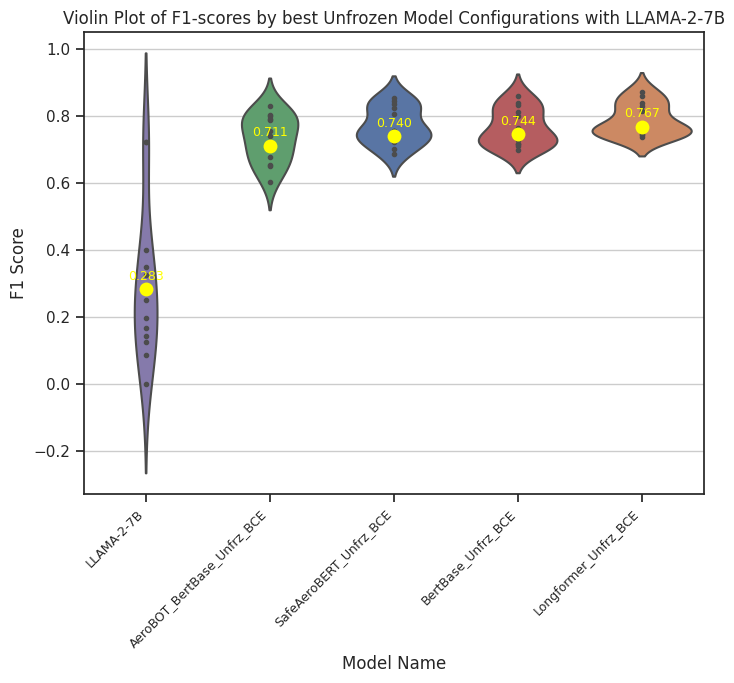

In [63]:
plt.figure(figsize=(8, 6))
sns.set_theme(style="ticks")
plt.grid()
sns.stripplot(data=results_gf[results_gf['Category'].isin(['macro avg'])], x="Model Name", y="f1-score", color='yellow', size=10, jitter=True)
sns.violinplot(data=results_gf[~results_gf['Category'].isin(cat_exclude)], x="Model Name", y="f1-score",
               inner="points", saturation=0.75, palette=model_palette)
plt.title('Violin Plot of F1-scores by best Unfrozen Model Configurations with LLAMA-2-7B')
for i in range(len(results_gf[results_gf['Category'].isin(['macro avg'])])):
    plt.text(results_gf[results_gf['Category'].isin(['macro avg'])].iloc[i]['Model Name'], results_gf[results_gf['Category'].isin(['macro avg'])].iloc[i]['f1-score'] + 0.02, 
             f"{results_gf[results_gf['Category'].isin(['macro avg'])].iloc[i]['f1-score']:.3f}", ha='center', va='bottom', fontsize=9, color='yellow')
plt.ylabel('F1 Score')
plt.xticks(rotation = 45, ha='right', fontsize=9)
plt.show()

In [64]:
print(classification_report(ytrue[:,0], np.array(fs_pred)[:,0]))

              precision    recall  f1-score   support

           0       0.33      0.42      0.37       518
           1       0.59      0.49      0.54       871

    accuracy                           0.47      1389
   macro avg       0.46      0.46      0.45      1389
weighted avg       0.49      0.47      0.47      1389



In [65]:
fs_format_errors = np.where(np.sum(np.array(fs_pred), axis=1)==0)[0]

In [66]:
print(classification_report(ytrue[:,0][~fs_format_errors], np.array(fs_pred)[:,0][~fs_format_errors]))

              precision    recall  f1-score   support

           0       0.30      0.40      0.34       196
           1       0.56      0.45      0.50       338

    accuracy                           0.43       534
   macro avg       0.43      0.42      0.42       534
weighted avg       0.46      0.43      0.44       534



In [67]:
gf_fs_f1_score = f1_score(ytrue[:,0][~fs_format_errors], np.array(fs_pred)[:,0][~fs_format_errors])
fs_f1_score = f1_score(ytrue[:,0], np.array(fs_pred)[:,0])

/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_cat

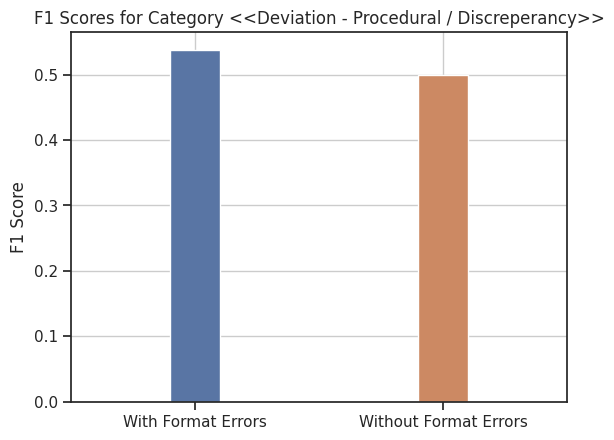

In [68]:
sns.barplot(y=[fs_f1_score, gf_fs_f1_score], x=['With Format Errors', 'Without Format Errors'], width=0.2)
plt.ylabel('F1 Score')
plt.title('F1 Scores for Category <<Deviation - Procedural / Discreperancy>>')
plt.grid()

In [69]:
fs_fe_per = (len(np.where(np.sum(np.array(fs_pred), axis=1)==0)[0])/len(np.array(fs_pred)))*100
zs_fe_per = (len(np.where(np.sum(np.array(zs_pred), axis=1)==0)[0])/len(np.array(zs_pred)))*100

/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_cat

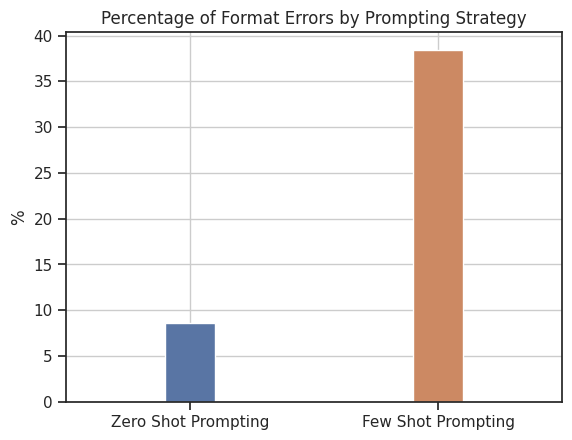

In [70]:
sns.barplot(y=[zs_fe_per, fs_fe_per], x=['Zero Shot Prompting', 'Few Shot Prompting'], width=0.2)
plt.ylabel('%')
plt.title('Percentage of Format Errors by Prompting Strategy')
plt.grid()

In [71]:
llama_results

,Model Name,Category,f1-score
0,LLAMA-2-7B,Deviation / Discrepancy - Procedural,0.750125
1,LLAMA-2-7B,Aircraft Equipment,0.281385
2,LLAMA-2-7B,Conflict,0.575406
3,LLAMA-2-7B,Inflight Event / Encounter,0.340237
4,LLAMA-2-7B,ATC Issue,0.232143
5,LLAMA-2-7B,Deviation - Altitude,0.263374
6,LLAMA-2-7B,Deviation - Track / Heading,0.062827
7,LLAMA-2-7B,Ground Event / Encounter,0.400742
8,LLAMA-2-7B,Flight Deck / Cabin / Aircraft Event,0.181818
9,LLAMA-2-7B,Ground Incursion,0.031008


In [72]:
results_full.sort_values(by=['f1-score', 'Category'], ascending=False)

,Model Name,Category,f1-score,Model
48,Longformer_Unfrz_BCE,Ground Excursion,0.871595,Longformer
38,Longformer_Unfrz_BCE,Conflict,0.860177,Longformer
12,BertBase_Unfrz_BCE,Ground Excursion,0.858268,BERT
30,SafeAeroBERT_Unfrz_BCE,Ground Excursion,0.852590,SafeAeroBERT
20,SafeAeroBERT_Unfrz_BCE,Conflict,0.844365,SafeAeroBERT
...,...,...,...,...
13,LLAMA-2-7B,No Specific Anomaly Occurred,0.132626,LLAMA-2-7B
10,LLAMA-2-7B,Airspace Violation,0.086331,LLAMA-2-7B
6,LLAMA-2-7B,Deviation - Track / Heading,0.062827,LLAMA-2-7B
9,LLAMA-2-7B,Ground Incursion,0.031008,LLAMA-2-7B


/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ensai/.pyenv/versions/3.10.12/envs/safran-nlp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarni

<Axes: xlabel='Category', ylabel='f1-score'>

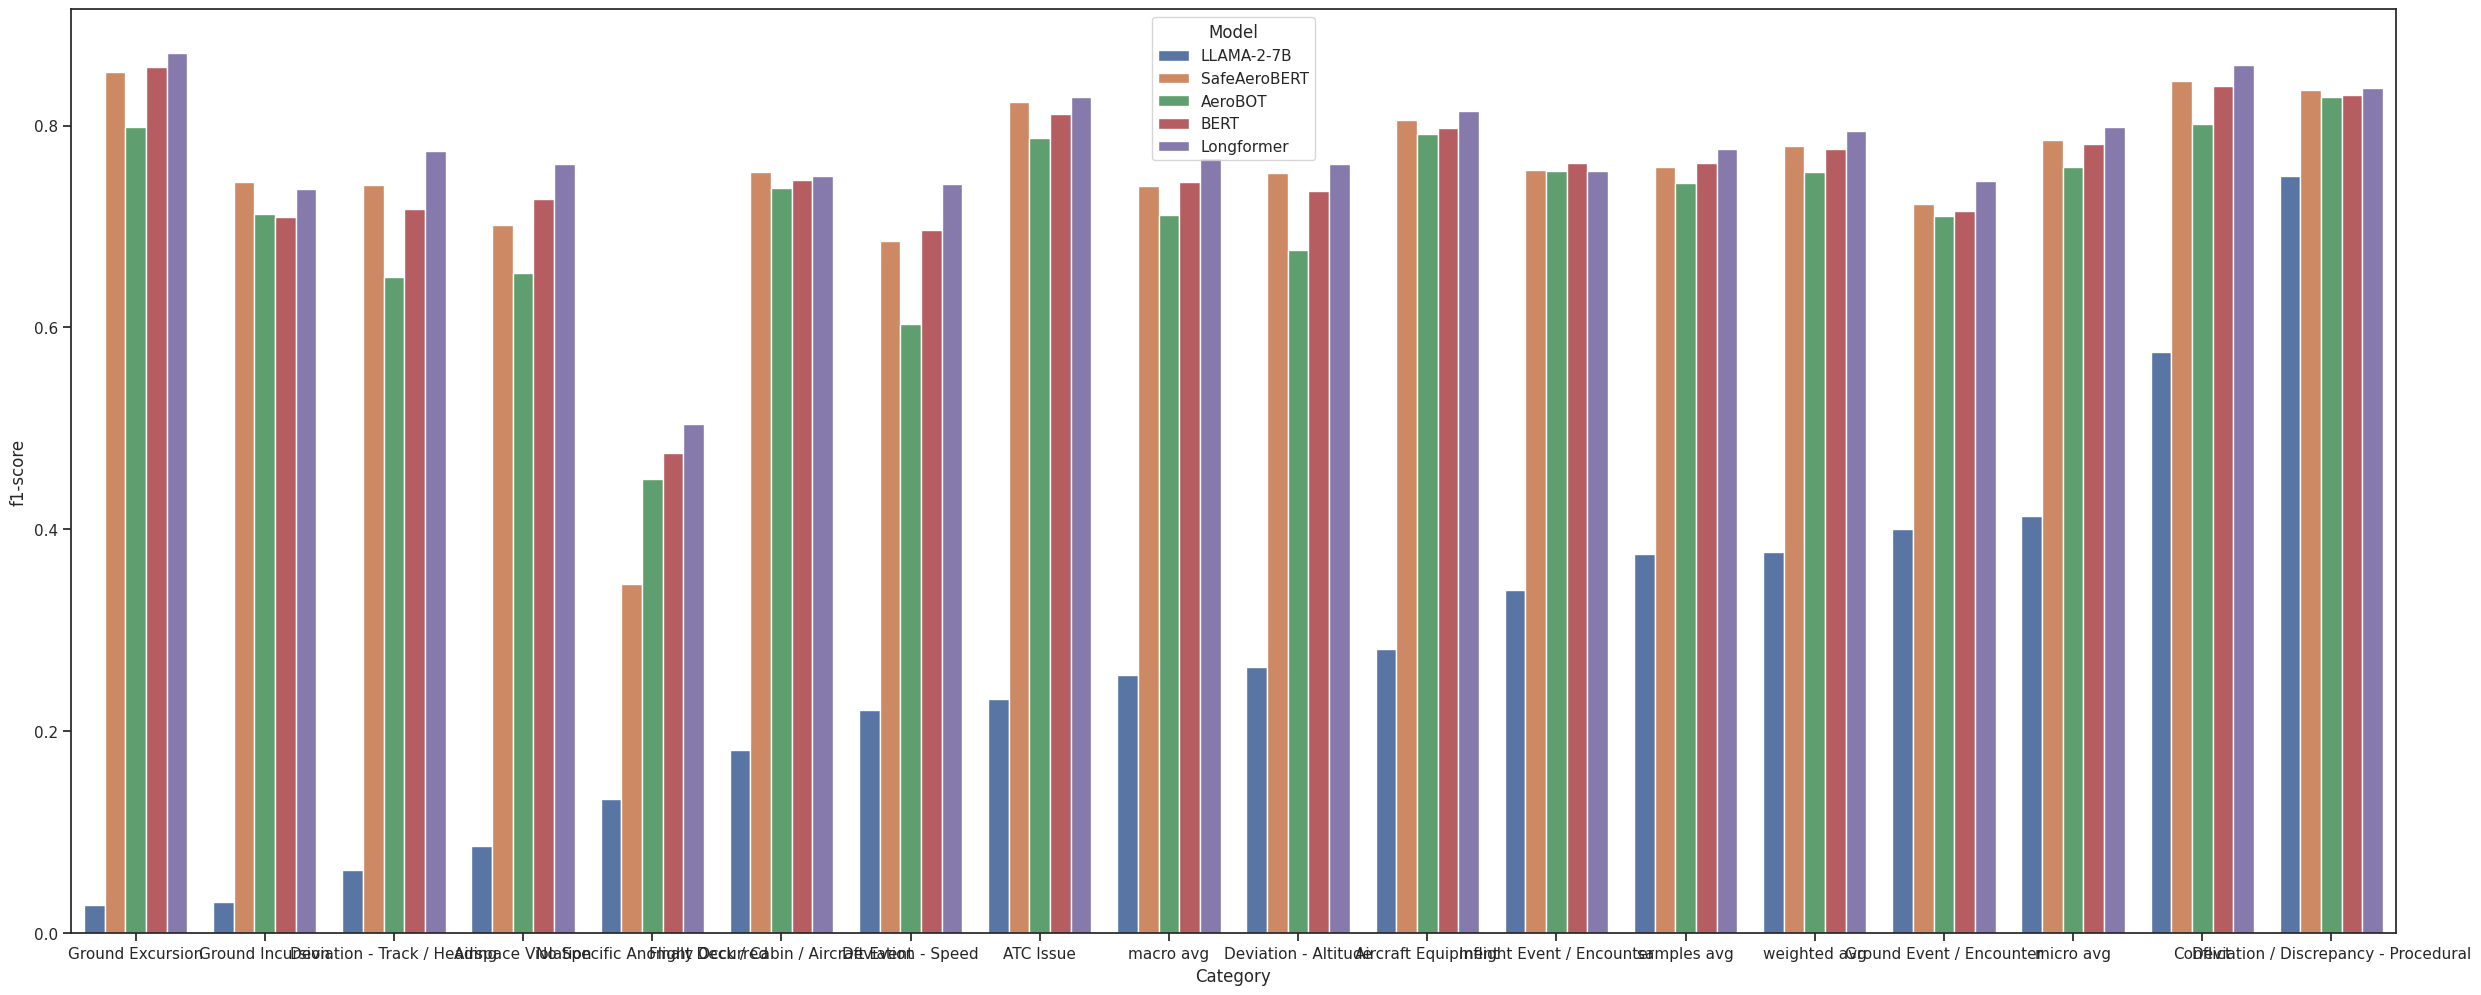

In [73]:
plt.figure(figsize=(30,12))
sns.barplot(data=results_full, x='Category', y='f1-score', hue='Model')

In [74]:
errors_idx

array([  19,   21,   28,   31,   38,   40,   63,   66,   70,  101,  117,
        127,  132,  138,  147,  148,  156,  161,  183,  194,  214,  230,
        235,  256,  272,  290,  295,  310,  329,  335,  339,  381,  384,
        385,  388,  395,  399,  401,  407,  433,  500,  530,  533,  551,
        555,  557,  575,  595,  598,  648,  659,  702,  705,  706,  707,
        713,  729,  746,  752,  754,  755,  757,  766,  773,  780,  783,
        797,  805,  820,  822,  828,  837,  839,  842,  851,  857,  859,
        863,  866,  883,  889,  890,  891,  892,  893,  903,  910,  970,
        972,  980,  991, 1011, 1050, 1054, 1068, 1079, 1088, 1116, 1122,
       1124, 1147, 1148, 1157, 1236, 1262, 1266, 1271, 1279, 1281, 1292,
       1293, 1295, 1296, 1301, 1316, 1319, 1327, 1349, 1376])

In [99]:
errors_idx_zs = np.where(np.sum(zs_pred, axis=1)==0)[0]

In [96]:
errors_idx_fs = np.where(np.sum(fs_pred, axis=1)==0)[0]

In [100]:
subset_clean_zs = subset.iloc[~errors_idx_zs]

In [101]:
subset_clean_fs = subset.loc[~errors_idx_fs]

In [102]:
subset_clean_zs

,Narrative,Anomaly
index,,
7677,We were cleared the FMS Bridge visual Runway 2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
598,Depart hotel at XA:00 for a XB:00 pushback. As...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
6114,The sprinkler system that sprays the outside o...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
317,I was very surprised to find that all three fl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
8363,Each airline; including mine; requires runway ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...
371,I was working Yorktown sector 50. I had aircra...,"[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
5257,I met a guy who wanted me to come fly with him...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
10710,RADAR training [was] in progress. Trainee cert...,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [103]:
subset.index

Index([ 6922,  5110,  2764,  2880,  5773,  8567,  8372,  7982,  4527,  1611,
       ...
       10355,  6363,  7140,  2964,  9280,  1576,  7319,  7546, 10519,  3443],
      dtype='int64', name='index', length=1389)

In [16]:
ytrue.shape

(1389, 14)

In [17]:
np.sum(ytrue, axis=0)

array([871, 380, 292, 359, 382, 196, 179, 227, 149, 126, 131, 147, 138,
        89])

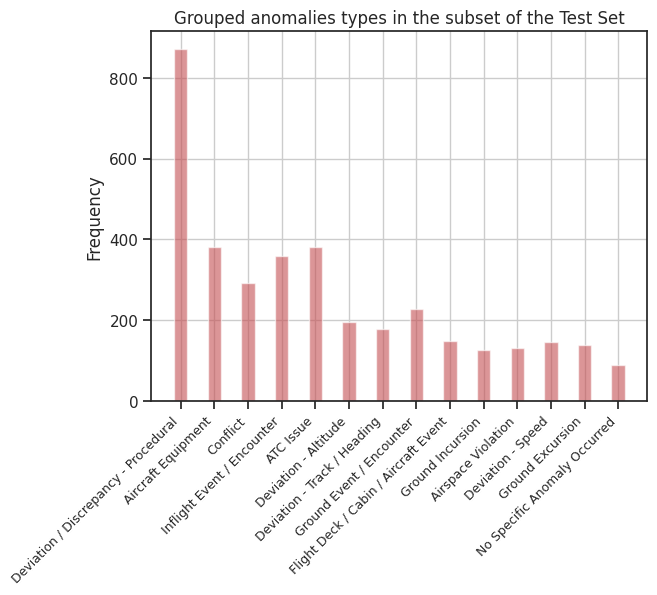

In [26]:
plt.bar(x = ANOMALY_LABELS, height= np.sum(ytrue, axis=0), color='r', alpha=0.6, width=0.4)
plt.xticks(rotation = 45, ha='right', fontsize=9)
plt.title('Grouped anomalies types in the subset of the Test Set')
plt.ylabel('Frequency')
plt.grid()
plt.show()